I will use this notebook to detect the field lines for each image in the dataset, which will allow for formation detection via player coordinates on the field, rather than the raw image. Change the path to the dataset and the path to the output director as needed.

In [140]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
path_to_data = "/Users/thomasmcconnell/Library/CloudStorage/OneDrive-PomonaCollege/School/CS153/Project/cs153-football-formation-id/sample_data"
path_for_output = "/Users/thomasmcconnell/Library/CloudStorage/OneDrive-PomonaCollege/School/CS153/Project/cs153-football-formation-id/field_lines_detection"
os.makedirs(path_for_output, exist_ok=True)

Now we get the images we want. I will start using sideline angle images as they are the only angle that most consistently has all 22 plays on the field in the image.

In [134]:
image_paths = []

angle = "sideline" #change to endzone or tight if wanted

# Grab images
for formation_folder in os.listdir(path_to_data):
    formation_path = os.path.join(path_to_data, formation_folder)
    
    if os.path.isdir(formation_path):
        for video_folder in os.listdir(formation_path):
            video_path = os.path.join(formation_path, video_folder)

            if os.path.isdir(video_path):
                for file in os.listdir(video_path):
                    if file.startswith(angle) and file.endswith(".png"):
                        full_path = os.path.join(video_path, file)
                        image_paths.append(full_path)


Now we load the image in and attempt to detect the field lines. We first convert the image to grayscale, then apply a Gaussian blur to reduce noise. We then use the Canny edge detector to find the edges in the image. Finally, we use the Hough transform to detect the lines in the image. The detected lines are then drawn on the original image for visualization.

In [ ]:
def detect_and_draw_lines(image, show_result=True):
    """
    Applies Canny edge detection and Hough Line Transform to detect and draw filtered lines on an image.
    
    Args:
        image (np.ndarray): Input BGR image.
        show_result (bool): Whether to display the image with detected lines.

    Returns:
        image_with_lines (np.ndarray): Image with lines drawn.
        filtered_lines (list): List of filtered lines (after length and angle check).
    """
    # edge detection
    canny_thresh1 = 30
    canny_thresh2 = 150
    hough_thresh = 100
    min_line_length = 150
    max_line_gap = 20
    min_length_filter = 50         
    angle_range_filter = (30, 150) # angles we keep

    # convert to grayscale and apply gaussian blur and canny
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, threshold1=canny_thresh1, threshold2=canny_thresh2)

    # hough line transform
    raw_lines = cv2.HoughLinesP(
        edges,
        rho=1,
        theta=np.pi/180,
        threshold=hough_thresh,
        minLineLength=min_line_length,
        maxLineGap=max_line_gap
    )

    filtered_lines = []

    if raw_lines is not None:
        for line in raw_lines:
            x1, y1, x2, y2 = line[0]
            length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
            angle = np.degrees(np.arctan2((y2 - y1), (x2 - x1)))
            angle = abs(angle)

            if length >= min_length_filter and (angle_range_filter[0] <= angle <= angle_range_filter[1]):
                filtered_lines.append((x1, y1, x2, y2))

    # draw the lines
    image_with_lines = image.copy()
    for x1, y1, x2, y2 in filtered_lines:
        cv2.line(image_with_lines, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=3)

    # show image
    if show_result:
        image_rgb = cv2.cvtColor(image_with_lines, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(15, 10))
        plt.imshow(image_rgb)
        plt.title("Detected & Filtered Lines")
        plt.axis("off")
        plt.show()

    return image_with_lines, filtered_lines


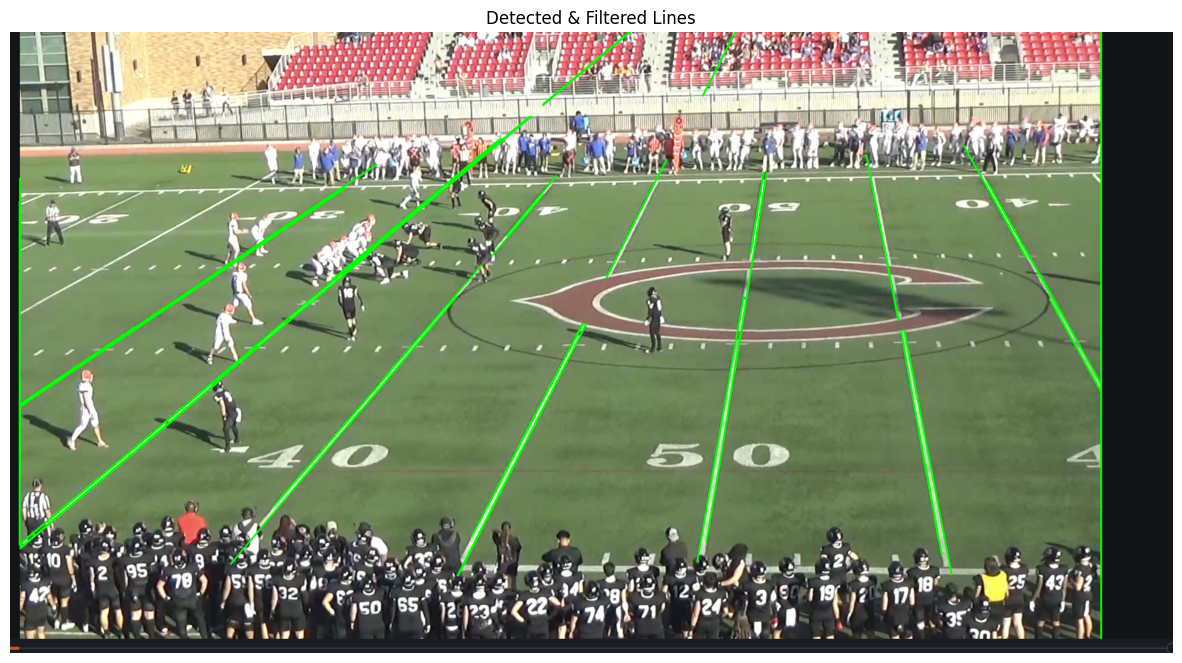

In [136]:
image_with_lines, image_lines = detect_and_draw_lines(image)

We can see that the field lines are deteced, but there is tons of noise in the image. We can try to reduce this noise in two ways: 1. We can apply a mask to the image to only detect lines in the field area. 2. We can use the Hough transform to filter out lines that are not long enough or not straight enough.

Below, we will first try to remove the background noise by applying a mask to the image of only green pixels.

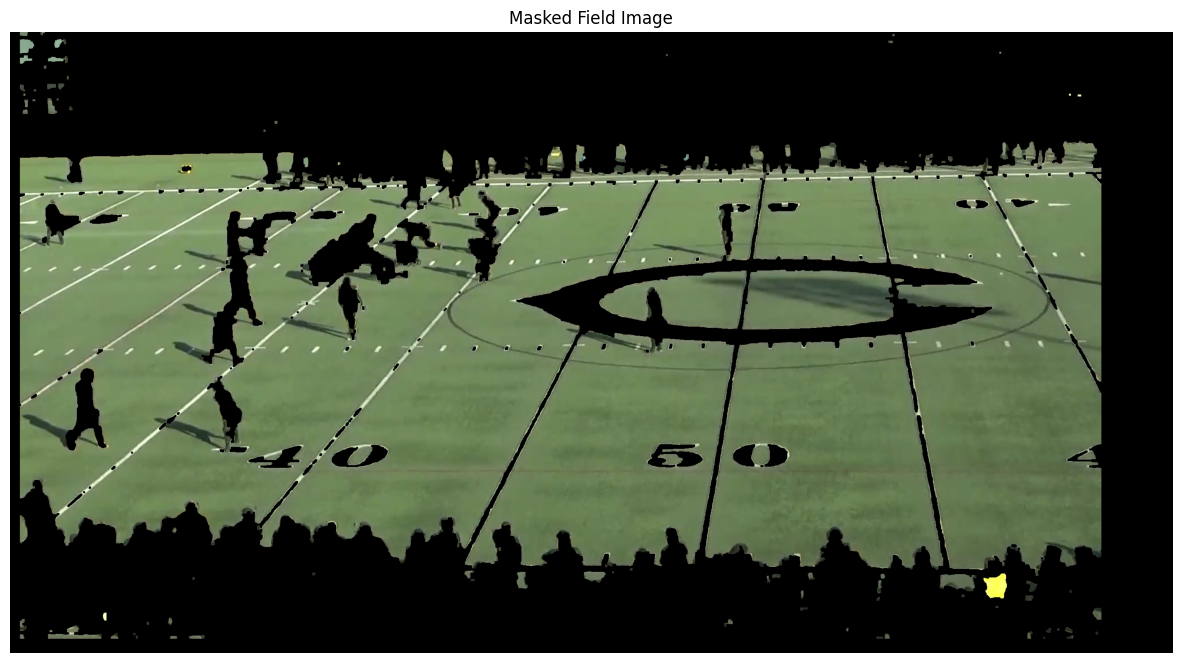

In [137]:
def apply_field_mask(image):
    """
    Applies a green color threshold mask to isolate the football field.
    
    Args:
        image (np.ndarray): Input BGR image.

    Returns:
        masked_image (np.ndarray): Image with only the field preserved.
        field_mask (np.ndarray): Binary mask of the field.
    """
    # we will use HSV color space for better color segmentation
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # we define green color range in HSV as 30-90 hue
    lower_green = np.array([30, 40, 40])
    upper_green = np.array([90, 255, 255])

    # binary mask for green color
    field_mask = cv2.inRange(hsv, lower_green, upper_green)

    # Use morpology to remove noise from our mask
    kernel = np.ones((5, 5), np.uint8)
    field_mask = cv2.morphologyEx(field_mask, cv2.MORPH_OPEN, kernel)
    field_mask = cv2.morphologyEx(field_mask, cv2.MORPH_CLOSE, kernel)

    # put mask back to original image
    masked_image = cv2.bitwise_and(image, image, mask=field_mask)

    return masked_image, field_mask

# display the mask
masked_image, field_mask = apply_field_mask(image)

plt.figure(figsize=(15,10))
plt.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))
plt.title("Masked Field Image")
plt.axis('off')
plt.show()


Now that we have mask, we will retry our hough transform, where hopefully we can detect the field lines better.

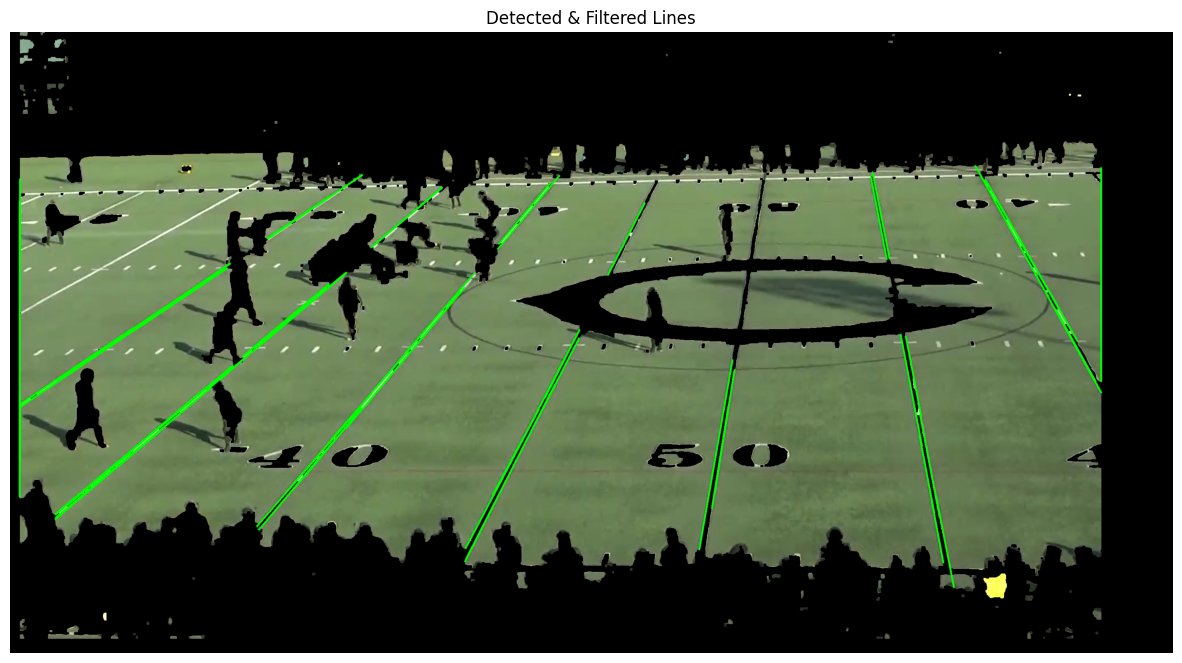

In [138]:
masked_image_with_lines, masked_lines = detect_and_draw_lines(masked_image)

When I got to this stage, I realized that without a ground truth of what the field lines are, I have no way of knowing if the lines are correct or not. Rather than try to create a homography matrix to warp the image to a top down view, I will instead use the yard lines to create a mask of the field area. This will allow me to hopefully automically remove most of the background area of the images. I cannot use the field lines (horizontal lines in a sideline image) to create the mask, as they are sometimes not visible in the image. I will instead use the yard lines (vertical lines in a sideline image) to create the mask. I will use the Hough transform to detect the yard lines, and then use these lines to create a mask of the field area. I will then apply this mask to the image to remove the background area. I will also remove anything that is more than 50% black in the mask for a given y value, as this is likely to be background area full of players on the sideline rather than field area. There is no football play where all 22 players would be lines up along the field like they are on the sideline.

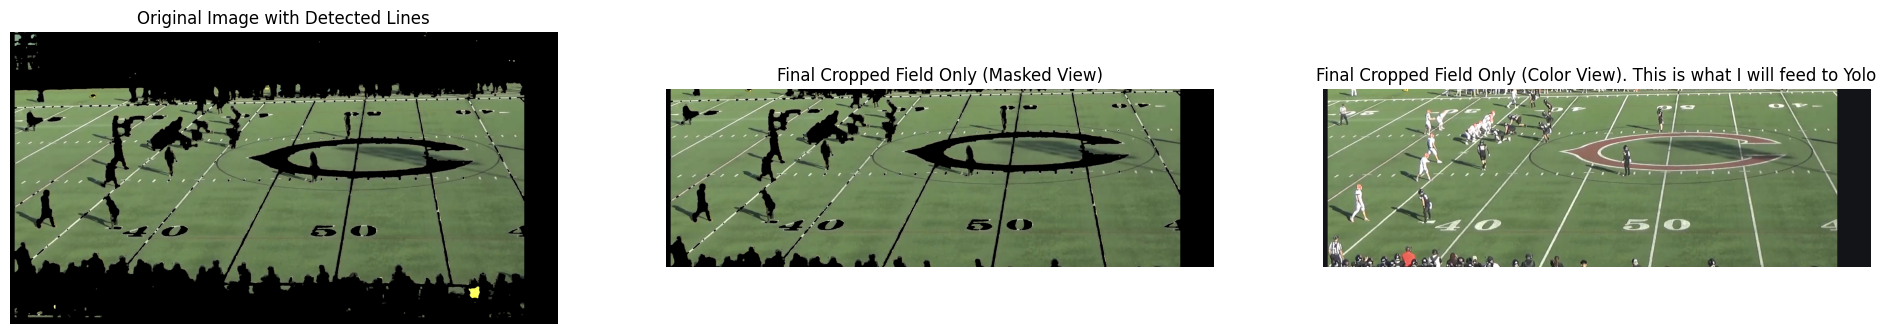

In [ ]:
def crop_image_to_field_region(image, filtered_lines, padding=10, black_thresh=50):
    """
    Crops the image to only the vertical region defined by detected lines,
    then trims extra black areas at top/bottom based on % black pixels.

    Args:
        image (np.ndarray): Original image.
        filtered_lines (list): List of (x1, y1, x2, y2) detected lines.
        padding (int): Pixels of extra padding above and below (optional).
        black_thresh (float): % black pixels threshold to remove row (0-100).

    Returns:
        cropped_image (np.ndarray): Clean cropped field image.
    """
    if not filtered_lines:
        raise ValueError("No lines provided for cropping.")

    #crop above highest and below lowest yard line
    y_coords = []
    for (x1, y1, x2, y2) in filtered_lines:
        y_coords.append(y1)
        y_coords.append(y2)
    top_y = max(min(y_coords) - padding, 0)
    bottom_y = min(max(y_coords) + padding, image.shape[0])
    cropped = image[int(top_y):int(bottom_y), :]

    # back to grayscale
    gray_cropped = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)

    # remove y rows that are mostly black (representing sidelines)
    _, binary = cv2.threshold(gray_cropped, 50, 255, cv2.THRESH_BINARY_INV)
    height, width = binary.shape
    black_pixel_thresh = (black_thresh / 100.0) * width

    # final crops
    new_top = 0
    for row in range(height):
        if np.sum(binary[row, :] > 0) < black_pixel_thresh:
            new_top = row
            break
    new_bottom = height
    for row in range(height - 1, -1, -1):
        if np.sum(binary[row, :] > 0) < black_pixel_thresh:
            new_bottom = row
            break
    final_cropped = cropped[new_top:new_bottom, :]

    # need crop dimensions for original
    return final_cropped, (top_y + new_top, top_y + new_bottom)

cropped_image, (crop_start_y, crop_end_y) = crop_image_to_field_region(masked_image, masked_lines, padding=20, black_thresh=50)

color_cropped_image = image[int(crop_start_y):int(crop_end_y), :]

# Display

original_rgb = cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB)
cropped_rgb = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)
color_cropped_rgb = cv2.cvtColor(color_cropped_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(24, 8))

plt.subplot(1, 3, 1)
plt.imshow(original_rgb)
plt.title("Original Image with Detected Lines")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(cropped_rgb)
plt.title("Final Cropped Field Only (Masked View)")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(color_cropped_rgb)
plt.title("Final Cropped Field Only (Color View). This is what I will feed to Yolo")
plt.axis('off')

plt.show()


While we were unable to create a homography with the lack of a pre existing ground truth, we were able to use the field lines to crop a lot of the noise out of the image, which will make it easier for a player detection model to accruately detect only the players on the field. This will hopefully make it easier to predict formations accurately. This notebook is a demonstration of image pre processing that will be applied to all images in the dataset.